In [1]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
import binascii
import cmath
import random
import matplotlib.pyplot as plt

In [2]:
NUM_SAMPLES = 16

ol=Overlay('./cordiccart2pol.bit')

In [5]:
ol.ip_dict


{'cordiccart2pol_0/s_axi_BUS_A': {'fullpath': 'cordiccart2pol_0/s_axi_BUS_A',
  'type': 'xilinx.com:hls:cordiccart2pol:1.0',
  'bdtype': None,
  'state': None,
  'addr_range': 65536,
  'phys_addr': 1073741824,
  'mem_id': 's_axi_BUS_A',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_BUS_A_ADDR_WIDTH': '6',
   'C_S_AXI_BUS_A_DATA_WIDTH': '32',
   'C_S_AXI_CONTROL_ADDR_WIDTH': '4',
   'C_S_AXI_CONTROL_DATA_WIDTH': '32',
   'Component_Name': 'design_1_cordiccart2pol_0_3',
   'clk_period': '10',
   'machine': '64',
   'combinational': '0',
   'latency': '227',
   'II': '4',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_S_AXI_BUS_A_BASEADDR': '0x40000000',
   'C_S_AXI_BUS_A_HIGHADDR': '0x4000FFFF',
   'C_S_AXI_CONTROL_BASEADDR': '0x40010000',
   'C_S_AXI_CONTROL_HIGHADDR': '0x4001FFFF'},
  'registers': {'x': {'address_offset': 16,
    'size': 32,
    'access': 'write-only',
    'description': 'Data signal of x',
    'fields': {'x': {'bit_offset': 0,
      'bit_w

In [6]:
cordic_ip=MMIO(0x40000000,10000)

In [7]:
r_error=np.zeros(NUM_SAMPLES)
theta_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
r_rmse=np.zeros(NUM_SAMPLES)
theta_rmse=np.zeros(NUM_SAMPLES)

In [16]:
for i in range(NUM_SAMPLES):
    #Generating random inputs
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    
    #Computing golden output
    cn=complex(x,y)
    cn=cmath.polar(cn)
    
    #Converting input to bytes to be sent to FPGA
    x=(struct.unpack('<I', struct.pack('<f', x))[0])
    y=(struct.unpack('<I', struct.pack('<f', y))[0])
    
    #Writing values to the FPGA
    cordic_ip.write(0x10,x)
    cordic_ip.write(0x18,y)
    
    #Starting and stopping the IP
    cordic_ip_ctrl=MMIO(0x40010000,10000)
    cordic_ip_ctrl.write(0x00,1)
    cordic_ip_ctrl.write(0x00,0)
    
    #Reading from IP
    r=hex(cordic_ip.read(0x20))
    r=r[2:]
    theta=hex(cordic_ip.read(0x30))
    theta=theta[2:]
    
    #Converting to float
    if r!=0:
        r=struct.unpack('>f', binascii.unhexlify(r))
        r=r[0]
    if theta!=0:
        theta=struct.unpack('>f', binascii.unhexlify(theta))
        theta=theta[0]
        
    #Comparing with golden output    
    r_error[i]="{0:.16f}".format(abs(r-cn[0]))
    theta_error[i]="{0:.16f}".format(abs(theta-cn[1]))

In [17]:

# Verifying Functionality
sum_sq_r=0
sum_sq_theta=0

for i in range(NUM_SAMPLES):
    sum_sq_r =sum_sq_r+(r_error[i]*r_error[i])
    r_rmse = np.sqrt(sum_sq_r / (i+1))
    sum_sq_theta =sum_sq_theta+(theta_error[i]*theta_error[i])
    theta_rmse = np.sqrt(sum_sq_theta / (i+1))
print("Radius RMSE: ", r_rmse, "Theta RMSE:", theta_rmse)    
if r_rmse-sum_sq_r<0.001 and theta_rmse-sum_sq_theta<0.001:
    print("PASS")
else:
    print("FAIL")

Radius RMSE:  8.976134954845934e-08 Theta RMSE: 1.6951658073489416e-05
PASS


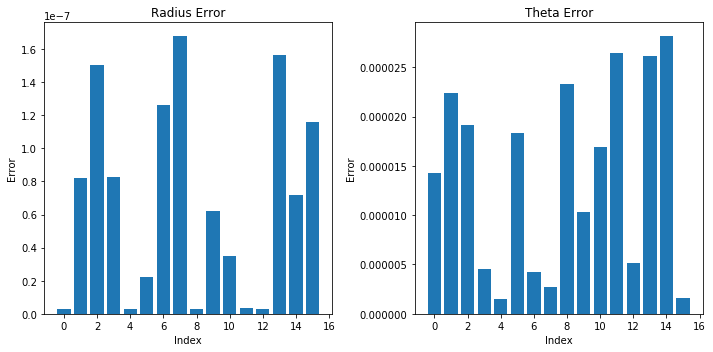

In [18]:
## Displaying Errors
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,r_error)
plt.title("Radius Error")
plt.xlabel("Index")
plt.ylabel("Error")
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,theta_error)
plt.title("Theta Error")
plt.xlabel("Index")
plt.ylabel("Error")
plt.tight_layout()
